In [2]:
%load_ext autoreload
%autoreload 2

In [24]:
import matplotlib.pyplot as plt, matplotlib
import numpy as np, healpy as hp, h5py
from scipy import stats, special, linalg, optimize
import scipy
import emcee, tqdm, corner

from pylab import cm

In [4]:
# Plotting modules
import matplotlib
from pylab import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', labelsize=16)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rc('legend',fontsize=16)
plt.rc('font',size=16)

In [ ]:
import emcee, corner

## Load data

In [16]:
nside=128
def downsize(arr, nbig, nsmall):
    return np.sum(np.reshape(arr, (-1,int((nbig/nsmall)**2+0.1))), axis=1)
def logit(p):
    return np.log(p/(1-p))
def expit(x):
    return 1/(1+np.exp(-x))
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))

In [17]:
data = {}
mag = 20.
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_hpx10.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = np.zeros(hp.nside2npix(128)).astype(int)
    data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    data['n'] = downsize(data['n'], 128, nside)[n2r]
    data['k'] = np.zeros(hp.nside2npix(128)).astype(int)
    data['k'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k_ast'][...]
    data['k'] = downsize(data['k'], 128, nside)[n2r]

In [21]:
data.keys()

dict_keys(['n', 'k'])

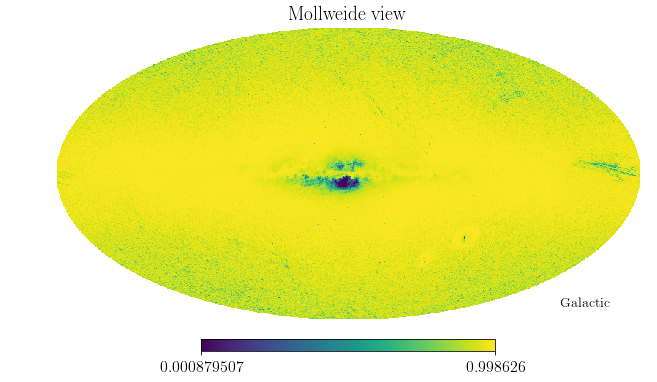

In [7]:
p = (data['k']+1)/(data['n']+2)
hp.mollview(p, coord=['C','G'])

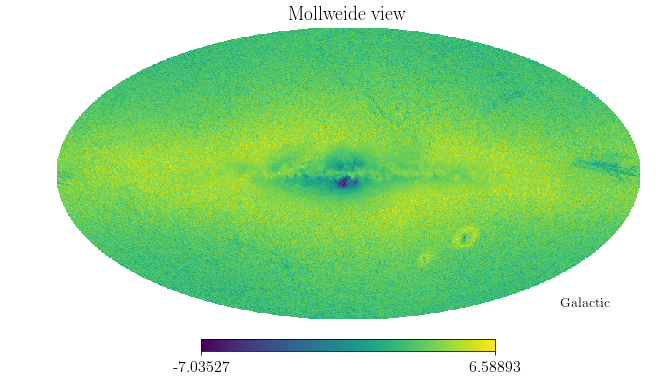

In [8]:
x = logit((data['k']+1)/(data['n']+2))
hp.mollview(x, coord=['C','G'])

## Spherical harmonic - wavelet transform

In [9]:
lmax = [10,30,100]

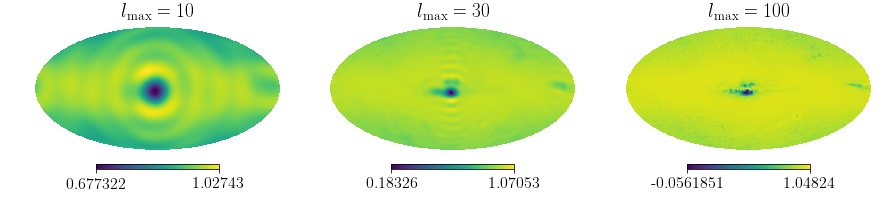

In [10]:
fig, ax = plt.subplots(1,len(lmax), figsize=(5*len(lmax), 5))
for i in range(len(lmax)):
    plt.sca(ax[i])
    alm_map = hp.map2alm((data['k']+1)/(data['n']+2), lmax=lmax[i])
    _map = hp.alm2map(alm_map, nside, verbose=False)
    hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title=r'$l_\mathrm{max} = %d$'%lmax[i])

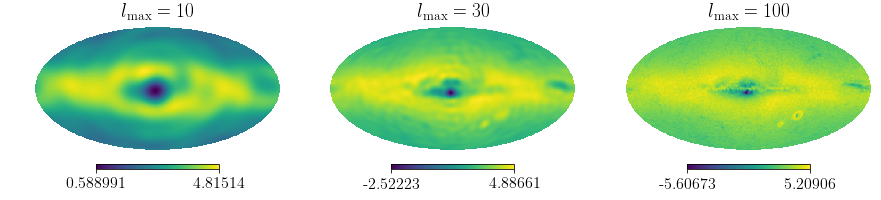

In [11]:
fig, ax = plt.subplots(1,len(lmax), figsize=(5*len(lmax), 5))
for i in range(len(lmax)):
    plt.sca(ax[i])
    alm_map = hp.map2alm(x, lmax=lmax[i])
    _map = hp.alm2map(alm_map, nside, verbose=False)
    hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title=r'$l_\mathrm{max} = %d$'%lmax[i])

### Power spectrum

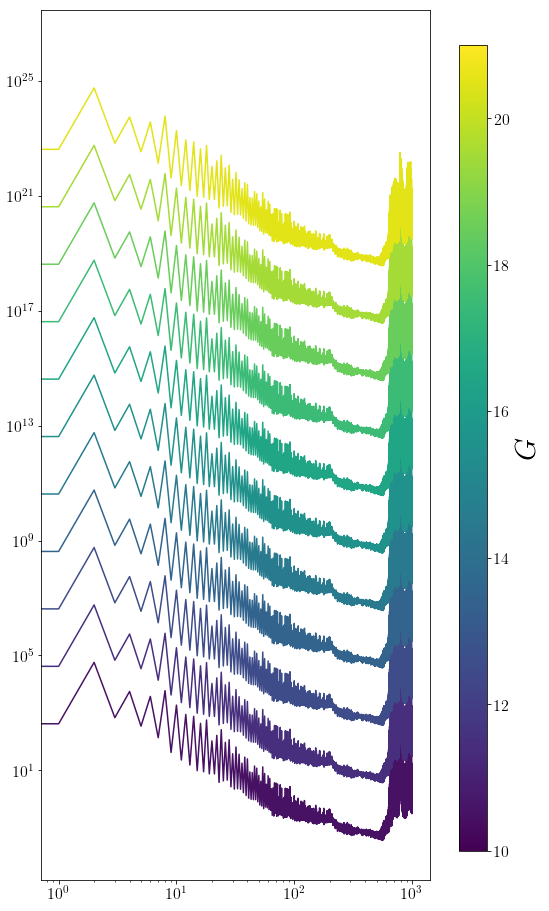

In [386]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    x = logit((data['k']+1)/(data['n']+2))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
    #plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2), color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
    
# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

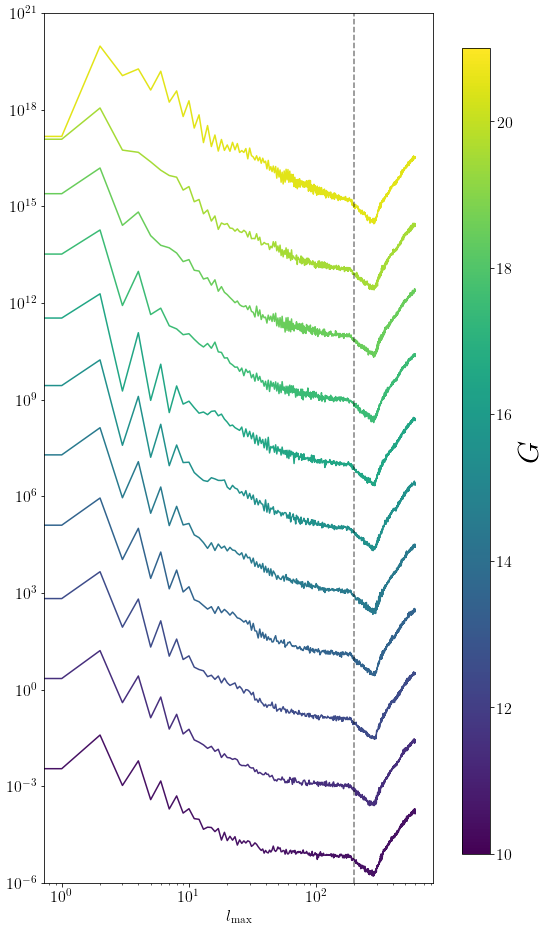

In [12]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=600
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        n_sample = np.zeros(hp.nside2npix(128))
        n_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        n_sample = downsize(n_sample, 128, nside)[n2r]
        k_sample = np.zeros(hp.nside2npix(128))
        k_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k'][...]
        k_sample = downsize(k_sample, 128, nside)[n2r]
        
    x = logit((k_sample+1)/(n_sample+2))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
    #plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2), color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l_\mathrm{max}$')
plt.ylim(1e-6, 1e21)

plt.plot([200,200],[1e-6,1e21],'--k', alpha=0.5)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

#plt.savefig('figs/powerspectrum_betamean_ast_nside%d.png' % nside, bbox_inches='tight')

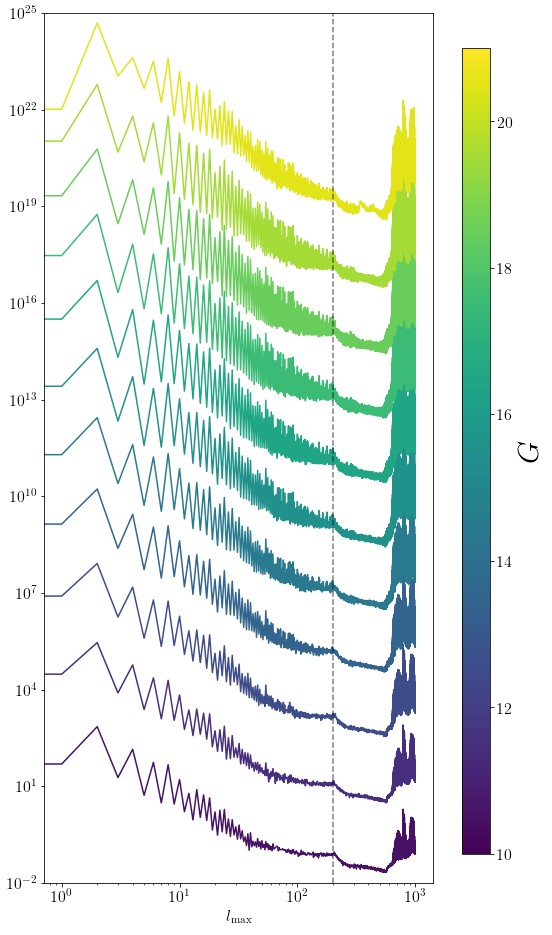

In [15]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        n_sample = np.zeros(hp.nside2npix(128))
        n_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        n_sample = downsize(n_sample, 128, nside)[n2r]
        k_sample = np.zeros(hp.nside2npix(128))
        k_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k'][...]
        k_sample = downsize(k_sample, 128, nside)[n2r]
        
    x = logit((k_sample+1)/(n_sample+2))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
    #plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2), color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l_\mathrm{max}$')
plt.ylim(1e-2, 1e25)

plt.plot([200,200],[1e-2,1e25],'--k', alpha=0.5)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

#plt.savefig('figs/powerspectrum_betamean_ast_nside%d.png' % nside, bbox_inches='tight')

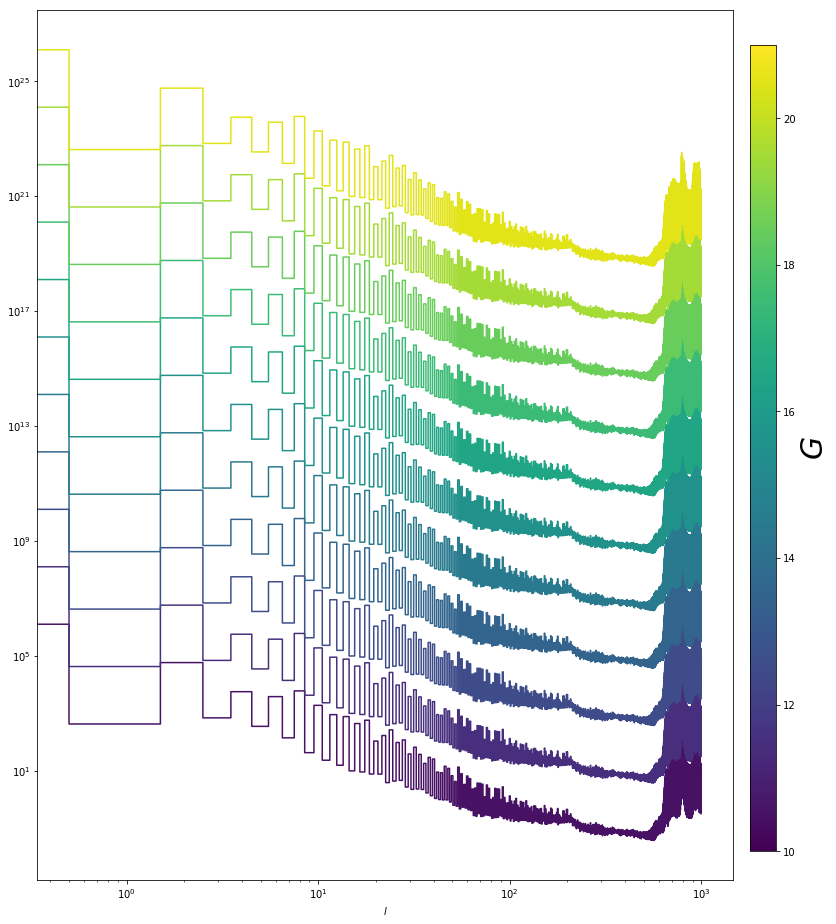

In [317]:
fig = plt.figure(figsize=(12,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    x = logit((data['k']+1)/(data['n']+2))
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2),
                color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

## Source density power spectrum

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


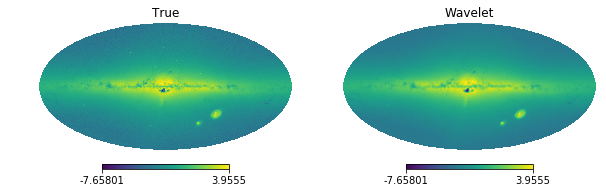

In [16]:
lmax=100

data = {}
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    data['n'] = np.zeros(hp.nside2npix(128))
    data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    data['n'] = downsize(data['n'], 128, nside)[n2r]


n_mean = np.sum(data['n'])/hp.nside2npix(nside)
x = np.where((data['n']>0), np.log(data['n']/n_mean),
                            -10)

fig, ax = plt.subplots(1,2, figsize=(10, 5))

plt.sca(ax[1])
alm_map = hp.map2alm(x, lmax=lmax)
_map = hp.alm2map(alm_map, nside, verbose=False)
hp.mollview(_map, coord=['C','G'], hold=True, notext=True, title='Wavelet')

plt.sca(ax[0])
hp.mollview(x, coord=['C','G'], hold=True, notext=True, title='True', min=np.min(_map), max=np.max(_map))

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


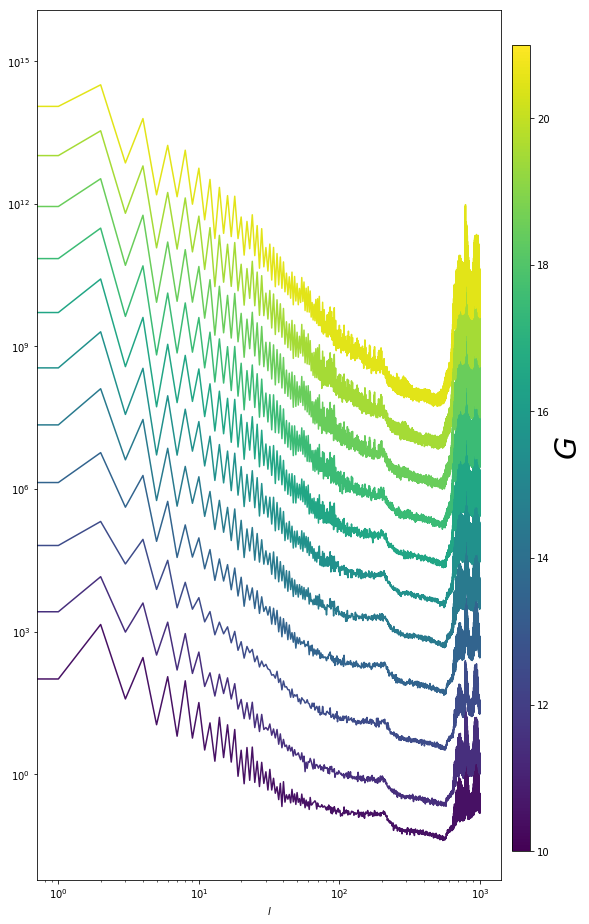

In [17]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):

    data = {}
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        data['n'] = np.zeros(hp.nside2npix(128))
        data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        data['n'] = downsize(data['n'], 128, nside)[n2r]
        
        
    n_mean = np.sum(data['n'])/hp.nside2npix(nside)
    x = np.where((data['n']>0), np.log(data['n']/n_mean), 0)
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(i)
    plt.plot(np.arange(lmax+1), spectrum, color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

/home/andy/py3/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


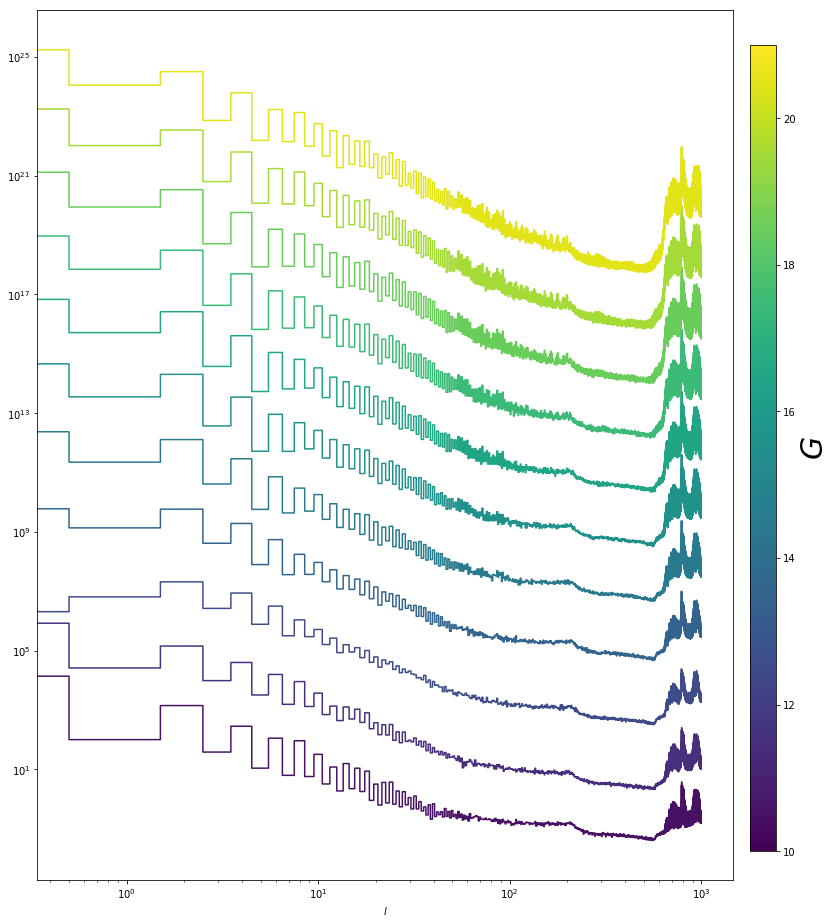

In [146]:
fig = plt.figure(figsize=(12,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=1000
for i, mag in enumerate(np.arange(10.5,21.,1.)):

    data = {}
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        data['n'] = np.zeros(hp.nside2npix(128))
        data['n'][hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        data['n'] = downsize(data['n'], 128, nside)[n2r]
        
        
    n_mean = np.sum(data['n'])/hp.nside2npix(nside)
    x = np.where((data['n']>0), np.log(data['n']/n_mean),
                                0)
        
    spectrum = hp.anafast(x, lmax=lmax) * 10**(2*i)
    plt.plot(np.repeat(np.arange(lmax+2),2)[1:-1]-0.5, np.repeat(spectrum,2),
                color=cmap((mag-mmin)/(mmax-mmin)))
plt.yscale('log'); plt.xscale('log')
plt.xlabel(r'$l$')

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

# Try again with Beta distribution

In [393]:
alpha = data['k']+1
beta = data['n']-data['k']+1

sample = scipy.stats.beta.rvs(alpha, beta, size=len(alpha))

pvals = scipy.stats.beta.cdf(sample, alpha, beta)
#pvals_mean = np.unique(scipy.stats.beta.cdf(alpha/(alpha+beta), alpha, beta))

In [403]:
np.max(_map)

3398.4246784779507

In [406]:
lmaxs = [10,30,100,300]
pvals_lmax = np.zeros((len(lmaxs), len(data['k'])))

integral = np.zeros((len(lmaxs), len(data['k'])))
for j in tqdm.tqdm_notebook(range(len(lmaxs))):
    alm_map = hp.map2alm(logit(sample), lmax=lmaxs[j])
    _map = hp.alm2map(alm_map, nside, verbose=False)

    pvals_lmax[j] = scipy.stats.beta.cdf(expit(_map), alpha, beta)

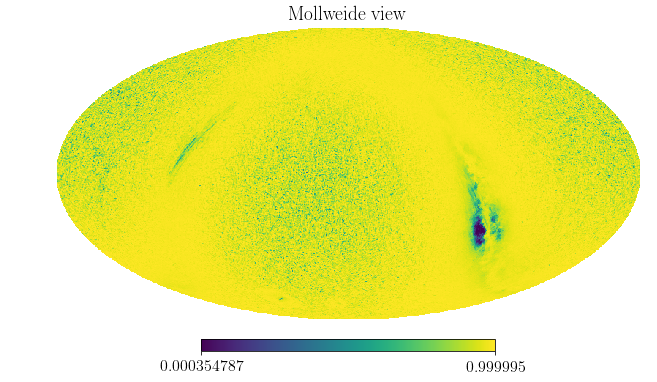

In [442]:
lmax=500
alm_map = hp.map2alm(logit(sample), lmax=lmax)
_map = hp.alm2map(alm_map, nside, verbose=False)
hp.mollview(expit(_map))

plt.savefig('figs/lmax%d_nside%d.png' % (lmax,nside), bbox_inches='tight')

In [427]:
_map

array([-4331.39755269, -4225.91329913, -3126.69202721, ...,
       -3990.06475449, -3759.7798747 , -3390.80937836])

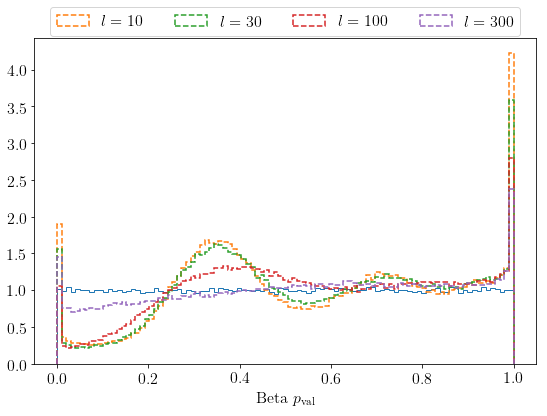

In [436]:
plt.figure(figsize=(9,6))

bins=np.linspace(0,1,100)
plt.hist(pvals, bins=bins, histtype='step', density=True);
#plt.hist(pvals_mean, bins=bins, histtype='step', density=True);

for j in range(len(lmaxs)):
    plt.hist(pvals_lmax[j], bins=bins, histtype='step', label=r'$l=%d$'%lmaxs[j], density=True, 
             linewidth=1.5, linestyle='--');
plt.legend(loc='upper center', ncol=len(lmaxs), bbox_to_anchor=(0.5,1.12))
#plt.yscale('log')

plt.xlabel(r'Beta $p_\mathrm{val}$')

plt.savefig('figs/BetaPval-test_ast_nside%d.png' % nside, bbox_inches='tight')

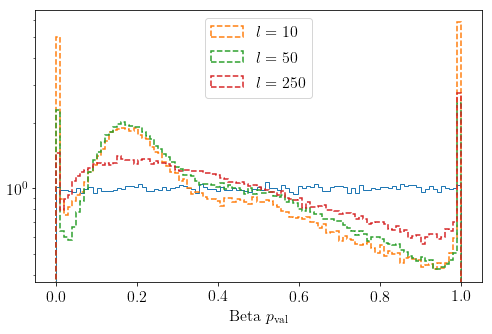

In [383]:
plt.figure(figsize=(8,5))

bins=np.linspace(0,1,100)
plt.hist(pvals, bins=bins, histtype='step', density=True);
#plt.hist(pvals_mean, bins=bins, histtype='step', density=True);

bins=np.linspace(0,1,100)
for j in range(len(lmaxs)):
    plt.hist(pvals_lmax[j], bins=bins, histtype='step', label=r'$l=%d$'%lmaxs[j], density=True, 
             linewidth=1.5, linestyle='--');
plt.legend(loc='upper center')
plt.yscale('log')

plt.xlabel(r'Beta $p_\mathrm{val}$')


plt.savefig('figs/BetaPval-test_ast_nside%d.png' % nside, bbox_inches='tight')

# Spectrum measurement error

In [21]:
import scipy

In [455]:
def loglike(l, Cl, a, gamma):
    return np.sum(gamma * np.log(a+l) - 0.5*(a+l)**(2*gamma) * (1/(a+l)**gamma - Cl)**2)

def loglike(l, Cl, params, grad=False):
    if not grad:
        x = (2*l+1)*Cl / model(l, params)
        lnl = np.sum( (l-0.5)*np.log(x)-x/2 )
        if np.isnan(lnl): print(params)
        return lnl
    else: 
        mod_vals, mod_grad = model(l, params, grad=grad)
        x = (2*l+1)*Cl / mod_vals
        x_prime = -(2*l+1)*Cl / mod_vals**2 * mod_grad
        lnl_val = np.sum( (l-0.5)*np.log(x)-x/2 )
        lnl_grad = np.sum( x_prime * ((l-0.5)/x - 1/2) , axis=1)
        
        return lnl_val, lnl_grad

In [495]:
def model(l, params):
    A = np.exp(params[0])
    gamma=params[1]
    return A*(l+1)**gamma

def model(l, params, grad=False):
    A = np.exp(params[0])
    a = np.exp(params[1])
    gamma=params[2]
    mod_vals = A*(a*(l+1)/(a+l))**gamma
    if not grad: return mod_vals
    mod_grad = np.array([A*(a*(l+1)/(a+l))**gamma,
                         A*(a*(l+1)/(a+l))**gamma * (gamma*l)/(a*(a+l)) * a,
                         A*(a*(l+1)/(a+l))**gamma * np.log(a*(l+1)/(a+l))])
    return mod_vals, mod_grad

def model(l, params, grad=False):
    A = np.exp(params[0])
    gamma=params[1]
    mod_vals = A*(l+1)**gamma
    if not grad: return mod_vals
    mod_grad = np.array([A*(l+1)**gamma,
                         A*(l+1)**gamma * np.log(l+1)])
    return mod_vals, mod_grad



In [314]:
def nll(x):
    lnl, grad = loglike(lvals, spectrum, x, grad=True)
    return -lnl, -grad

fmod = lambda x: nll(x)[0]
fgrad = lambda x: nll(x)[1]
scipy.optimize.approx_fprime(result['x'], fmod, 1e-8), fgrad(result['x'])

(array([77641.84847474,   700.05189627, -9443.575982  ]),
 array([77641.84178475,   700.05208946, -9443.57733674]))

In [316]:
lmax=190
lvals = np.arange(lmax+1)
mag=15.
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))
        
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
    magid = np.argwhere(hf['magval'][...]==mag)[0,0]
    n_sample = np.zeros(hp.nside2npix(128))
    n_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
    n_sample = downsize(n_sample, 128, nside)[n2r]
    k_sample = np.zeros(hp.nside2npix(128))
    k_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k'][...]
    k_sample = downsize(k_sample, 128, nside)[n2r]
    
x = logit((k_sample+1)/(n_sample+2))
spectrum = hp.anafast(x, lmax=lmax)

ValueError: cannot reshape array of size 196608 into shape (0)

In [131]:
nll = lambda x: -loglike(lvals, spectrum, x)

result = scipy.optimize.minimize(nll, np.array([0.01,20.,-2]), method='Powell')
result

   direc: array([[ -0.04241197, -11.27408481,  -0.69274536],
       [  0.        ,   1.        ,   0.        ],
       [  0.06880338,  -3.27750968,  -0.07342362]])
     fun: -79888.81212956586
 message: 'Optimization terminated successfully.'
    nfev: 305
     nit: 8
  status: 0
 success: True
       x: array([-11.99169717,  29.60511529,  -4.03244382])

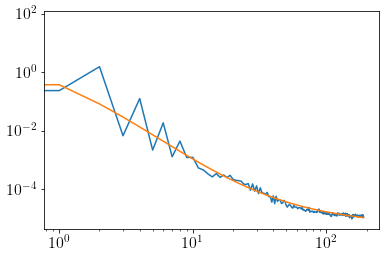

In [132]:
plt.plot(lvals, spectrum)
plt.plot(lvals, model(lvals, result['x']))
plt.yscale('log'); plt.xscale('log')


In [52]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=10.; mmax=21.

lmax=600
lvals = np.arange(lmax+1)
var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)
for i, mag in enumerate(np.arange(10.5,21.,1.)):
        
    with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts.h', 'r') as hf:
        magid = np.argwhere(hf['magval'][...]==mag)[0,0]
        n_sample = np.zeros(hp.nside2npix(128))
        n_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['n'][...]
        n_sample = downsize(n_sample, 128, nside)[n2r]
        k_sample = np.zeros(hp.nside2npix(128))
        k_sample[hf[str(magid)]['hpx'][...]] = hf[str(magid)]['k'][...]
        k_sample = downsize(k_sample, 128, nside)[n2r]
        
    x = logit((k_sample+1)/(n_sample+2))
        
    spectrum = hp.anafast(x, lmax=lmax)
    plt.plot(lvals, spectrum*10**(2*float(i)), color=cmap((mag-mmin)/(mmax-mmin)))
    plt.fill_between(lvals, spectrum*var_lower*10**(2*float(i)), 
                            spectrum*var_upper*10**(2*float(i)), color=cmap((mag-mmin)/(mmax-mmin)),
                    alpha=0.5)

    plt.plot(np.arange(190), model(np.arange(190), result['x'])*10**(2*float(i)), '--r')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l_\mathrm{max}$')
plt.ylim(1e-6, 1e21)

plt.plot([190,190],[1e-6,1e21],'--k', alpha=0.5)

# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=30)

#plt.savefig('figs/powerspectrum_betamean_fit_ast_nside%d.png' % nside, bbox_inches='tight')

ValueError: cannot reshape array of size 196608 into shape (0)

<Figure size 576x1152 with 0 Axes>

# High resolution

In [496]:
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    print(hf.keys())

<KeysViewHDF5 ['10.5', '11.5', '12.5', '13.5', '14.5', '15.5', '16.5', '17.5', '18.5', '19.5', '20.5', '8.5', '9.5', 'full', 'magval']>


In [504]:
lmax=100
lvals = np.arange(lmax+1)
mag=15.
        
high_level=10
nside=512
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))
    
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    n_sample = hf['full']['n'][...]
    n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
    k_sample = hf['full']['k_ast'][...]
    k_sample = downsize(k_sample, 2**high_level, nside)[n2r]
    
x = logit((k_sample+1)/(n_sample+2))
spectrum_full = hp.anafast(x, lmax=lmax)

In [505]:
nll = lambda x: -loglike(lvals, spectrum_full, x)
result = scipy.optimize.minimize(nll, np.array([0.,-2]), method='Powell')
result

   direc: array([[ 0.        ,  1.        ],
       [ 2.00072109, -0.49101737]])
     fun: -18175.740010417554
 message: 'Optimization terminated successfully.'
    nfev: 109
     nit: 4
  status: 0
 success: True
       x: array([-0.81516248, -2.55426537])

In [506]:
def nll(x):
    lnl, lnl_grad = loglike(lvals, spectrum_full, x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -18175.74007487874
     jac: array([-4.01242978e-06, -7.52091847e-06])
 message: 'Optimization terminated successfully.'
    nfev: 50
    nhev: 0
     nit: 3
    njev: 63
  status: 0
 success: True
       x: array([-0.81489922, -2.55429039])

Text(0.5, 0, '$l_\\mathrm{max}$')

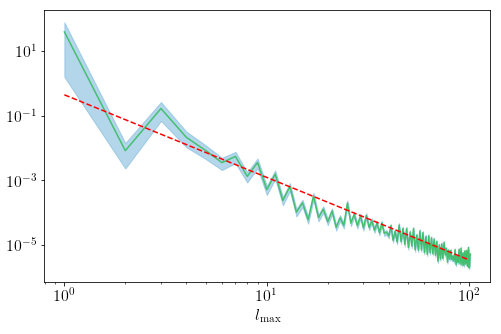

In [507]:
fig = plt.figure(figsize=(8,5))

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)

plt.plot(lvals+1, spectrum_full, color=cmap((mag-mmin)/(mmax-mmin)))
plt.fill_between(lvals+1, spectrum_full*var_lower, 
                        spectrum_full*var_upper, color=cm.Blues(0.5),
                alpha=0.5)

plt.plot(np.arange(100)+1, model(np.arange(100), result['x']), '--r')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l_\mathrm{max}$')

In [508]:
pll = lambda x: loglike(lvals, spectrum_full, x)
nstep=5000; nwalkers=10; ndim=2
p0_walkers=np.random.normal(result['x'], np.abs(result['x'])/1000, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, pll)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

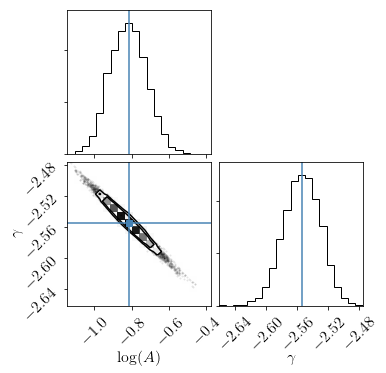

In [509]:
burnt = sampler.chain[:,int(nstep/2)::3,:].reshape(-1,ndim)
corner.corner(burnt[:,:], labels=[r'$\log(A)$',r'$\gamma$'], truths=result['x']);
plt.savefig('figs/lmodel-pl_corner_ast.png', bbox_inches='tight')

In [471]:
nll = lambda x: -loglike(lvals, spectrum_full, x)
result = scipy.optimize.minimize(nll, np.array([0.,2.,-2]), method='Powell')
result

   direc: array([[ 1.6904899 ,  3.30455155, -0.46863697],
       [ 0.73700512,  1.21074512,  0.04964173],
       [ 0.17130342,  0.24232826, -0.03463657]])
     fun: -18165.844941663974
 message: 'Optimization terminated successfully.'
    nfev: 271
     nit: 7
  status: 0
 success: True
       x: array([-0.73346759, 11.48948022, -2.62789621])

In [477]:
def nll(x):
    lnl, lnl_grad = loglike(lvals, spectrum_full, x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -18229.40103778239
     jac: array([-0.10172273, -0.41085695,  1.52819336])
 message: 'Optimization terminated successfully.'
    nfev: 874
    nhev: 0
     nit: 854
    njev: 4435
  status: 0
 success: True
       x: array([ 0.97281992,  4.75548233, -3.41244397])

In [478]:
pll = lambda x: loglike(lvals, spectrum_full, x)
nstep=5000; nwalkers=10; ndim=3
p0_walkers=np.random.normal(result['x'], np.abs(result['x'])/1000, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, pll)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

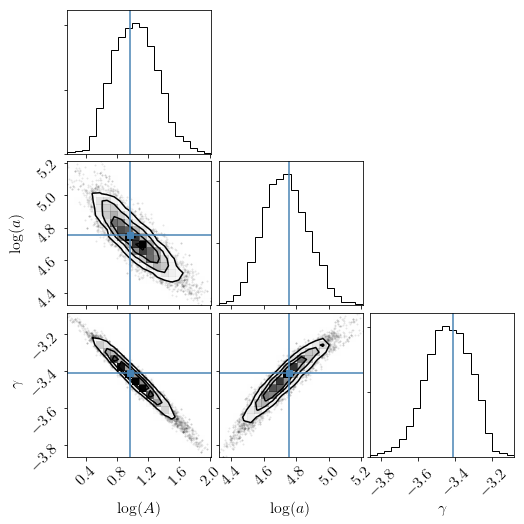

In [480]:
burnt = sampler.chain[:,int(nstep/2)::3,:].reshape(-1,ndim)
corner.corner(burnt[:,:], labels=[r'$\log(A)$','$\log(a)$',r'$\gamma$'], truths=result['x']);
plt.savefig('figs/lmodel_corner_ast.png', bbox_inches='tight')

Text(0.5, 0, '$l_\\mathrm{max}$')

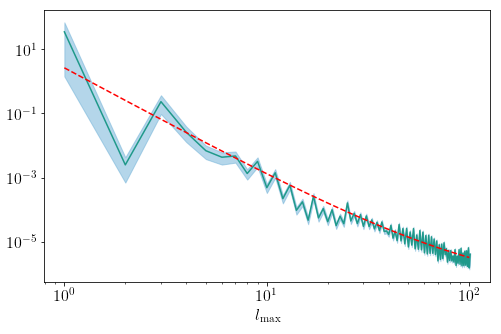

In [481]:
fig = plt.figure(figsize=(8,5))

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)

plt.plot(lvals+1, spectrum_full, color=cmap((mag-mmin)/(mmax-mmin)))
plt.fill_between(lvals+1, spectrum_full*var_lower, 
                        spectrum_full*var_upper, color=cm.Blues(0.5),
                alpha=0.5)

plt.plot(np.arange(100)+1, model(np.arange(100), result['x']), '--r')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l_\mathrm{max}$')
#plt.plot([100,100],[1e-20,1e40],'--k', alpha=0.5)

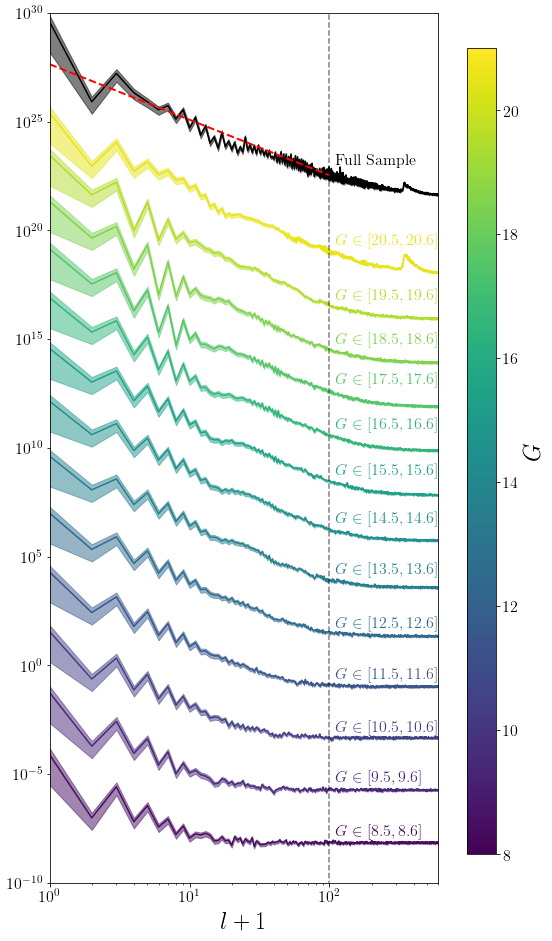

In [510]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=21.

high_level=10

lmax=600; nside=512; lmax_fit=100
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))
lvals = np.arange(lmax+1)
var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)

with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    for i, mag in tqdm.tqdm_notebook(enumerate(hf['magval'][...]), total=len(hf['magval'][...])):    
        #if i>3: continue
        n_sample = np.zeros(hp.nside2npix(2**high_level))
        n_sample[hf['%.1f' % mag]['hpx'][...]] = hf['%.1f' % mag]['n'][...]
        n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
        k_sample = np.zeros(hp.nside2npix(2**high_level))
        k_sample[hf['%.1f' % mag]['hpx'][...]] = hf['%.1f' % mag]['k_ast'][...]
        k_sample = downsize(k_sample, 2**high_level, nside)[n2r]
        
        x = logit((k_sample+1)/(n_sample+2))

        spectrum = hp.anafast(x, lmax=lmax)
        plt.plot(lvals+1, spectrum*10**(2*float(i)), color=cmap((mag-mmin)/(mmax-mmin)))
        plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(i)), 
                                spectrum*var_upper*10**(2*float(i)), color=cmap((mag-mmin)/(mmax-mmin)),
                        alpha=0.5)
        
#         plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x'])*10**(2*float(i)) \
#                                  * spectrum[lmax_fit]/model(lmax_fit, result['x']), '--r', alpha=0.7)
        
        plt.text(lmax_fit*1.1, spectrum[lmax_fit]*10**(2*float(i+0.15)), r'$G\in[%.1f,%.1f]$'%(mag,mag+0.1),
                 ha='left', color=cmap((mag-mmin)/(mmax-mmin)))
    
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    n_sample = hf['full']['n'][...]
    n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
    k_sample = hf['full']['k_ast'][...]
    k_sample = downsize(k_sample, 2**high_level, nside)[n2r]
x = logit((k_sample+1)/(n_sample+2))
spectrum_full = hp.anafast(x, lmax=lmax)

plt.plot(lvals+1, spectrum_full*10**(2*float(i+2)), color='k')
plt.fill_between(lvals+1, spectrum_full*var_lower*10**(2*float(i+2)), 
                        spectrum_full*var_upper*10**(2*float(i+2)), color='k',
                alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x'])*10**(2*float(i+2)), 
         '--r', linewidth=2)
plt.text(lmax_fit*1.1, spectrum_full[lmax_fit]*10**(2*float(i+2.15)), r'Full Sample',
             ha='left', color='k')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.plot([lmax_fit,lmax_fit],[1e-20,1e40],'--k', alpha=0.5)
plt.ylim(1e-10, 1e30)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

plt.savefig('figs/powerspectrum_betamean_fit-pl_ast_nside%d.png' % nside, bbox_inches='tight')

# Resampling

In [156]:
high_level=10
nside=256
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    n_sample = hf['full']['n'][...]
    n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
    k_sample = hf['full']['k_ast'][...]
    k_sample = downsize(k_sample, 2**high_level, nside)[n2r]

alpha = k_sample+1
beta = n_sample-k_sample+1

sample = scipy.stats.beta.rvs(alpha, beta, size=len(alpha))

pvals = scipy.stats.beta.cdf(sample, alpha, beta)

In [157]:
lmaxs = [10,100,1000]
pvals_lmax = np.zeros((len(lmaxs), len(alpha)))

integral = np.zeros((len(lmaxs), len(alpha)))
for j in tqdm.tqdm_notebook(range(len(lmaxs))):
    alm_map = hp.map2alm(logit(sample), lmax=lmaxs[j])
    _map = hp.alm2map(alm_map, nside, verbose=False)

    pvals_lmax[j] = scipy.stats.beta.cdf(expit(_map), alpha, beta)

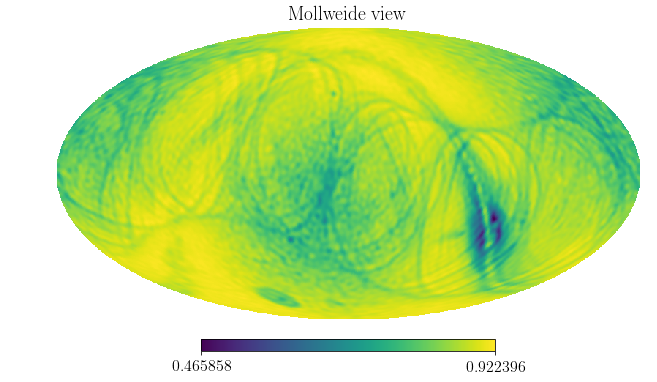

In [158]:
lmax=100
alm_map = hp.map2alm(logit(sample), lmax=lmax)
_map = hp.alm2map(alm_map, nside, verbose=False)
hp.mollview(expit(_map))

#plt.savefig('figs/lmax%d_nside%d.png' % (lmax,nside), bbox_inches='tight')

In [427]:
_map

array([-4331.39755269, -4225.91329913, -3126.69202721, ...,
       -3990.06475449, -3759.7798747 , -3390.80937836])

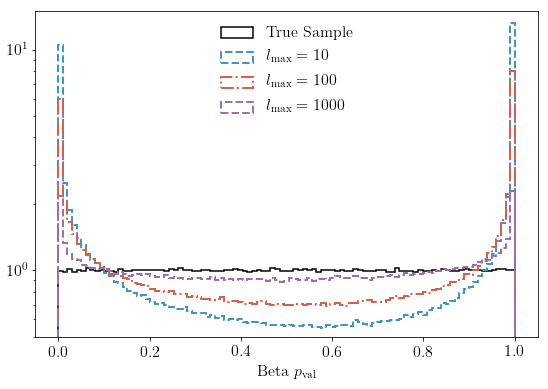

In [160]:
plt.figure(figsize=(9,6))

bins=np.linspace(0,1,100)
plt.hist(pvals, bins=bins, histtype='step', density=True, color='k', linewidth=1.5, label='True Sample');
#plt.hist(pvals_mean, bins=bins, histtype='step', density=True);

colors = [cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)]
linestyles = ['--', '-.', '--']

for j in range(len(lmaxs)):
    plt.hist(pvals_lmax[j], bins=bins, histtype='step', label=r'$l_\mathrm{max}=%d$'%lmaxs[j], density=True, 
             linewidth=2, linestyle=linestyles[j], color=colors[j]);
plt.legend(loc='upper center', ncol=1, frameon=False)#, bbox_to_anchor=(0.5,0.9))
plt.yscale('log')
plt.ylim(0.5,15)

plt.xlabel(r'Beta $p_\mathrm{val}$')

plt.savefig('figs/BetaPval-test_ast_nside%d.png' % nside, bbox_inches='tight')

# RVS sample

In [511]:
lmax_fit=100
lvals = np.arange(lmax_fit+1)
mag=15.
        
high_level=10
nside=512
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))
    
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    n_sample = hf['full']['n'][...]
    n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
    k_sample = hf['full']['k_rv'][...]
    k_sample = downsize(k_sample, 2**high_level, nside)[n2r]
    
x = logit((k_sample+1)/(n_sample+2))
spectrum_full = hp.anafast(x, lmax=lmax_fit)

In [512]:
nll = lambda x: -loglike(lvals, spectrum_full, x)
result = scipy.optimize.minimize(nll, np.array([0.,-4]), method='Powell')
result

   direc: array([[-1.32373121,  0.29245506],
       [-0.60280932,  0.1734415 ]])
     fun: -18819.421253146953
 message: 'Optimization terminated successfully.'
    nfev: 207
     nit: 7
  status: 0
 success: True
       x: array([ 1.32683028, -2.97071918])

In [513]:
def nll(x):
    lnl, lnl_grad = loglike(lvals, spectrum_full, x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -18819.421391666012
     jac: array([-3.27731278e-05, -6.51975907e-05])
 message: 'Optimization terminated successfully.'
    nfev: 5
    nhev: 0
     nit: 4
    njev: 24
  status: 0
 success: True
       x: array([ 1.32824171, -2.97102361])

In [515]:
fmod = lambda x: nll(x)[0]
fgrad = lambda x: nll(x)[1]
scipy.optimize.approx_fprime(np.array([0.01,-2]), fmod, 1e-8), fgrad(np.array([0.01,-2.]))

(array([ 4490.7341362 , 19227.25095937]),
 array([ 4490.73433473, 19227.2512315 ]))

In [516]:
pll = lambda x: loglike(lvals, spectrum_full, x)
nstep=5000; nwalkers=10; ndim=2
p0_walkers=np.random.normal(result['x'], np.abs(result['x'])/1000, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, pll)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

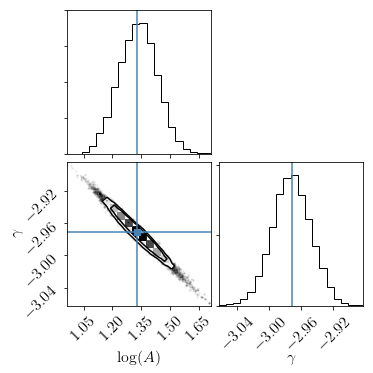

In [518]:
burnt = sampler.chain[:,int(nstep/2)::2,:].reshape(-1,ndim)
corner.corner(burnt, labels=[r'$\log(A)$',r'$\gamma$'], truths=result['x']);
plt.savefig('figs/lmodel-pl_corner_rvs.png', bbox_inches='tight')

In [487]:
nll = lambda x: -loglike(lvals, spectrum_full, x)
result = scipy.optimize.minimize(nll, np.array([0.,1.,-4]), method='Powell')
result

   direc: array([[1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.16530602, 0.56579953, 0.04414682]])
     fun: -18844.562361506145
 message: 'Optimization terminated successfully.'
    nfev: 319
     nit: 8
  status: 0
 success: True
       x: array([ 1.52977516,  6.04271627, -3.13168858])

In [488]:
def nll(x):
    lnl, lnl_grad = loglike(lvals, spectrum_full, x, grad=True)
    return -lnl, -lnl_grad

result= scipy.optimize.minimize(nll, result['x'], method='Newton-CG', jac=True, options={'maxiter':1000})
result

     fun: -18863.583010800645
     jac: array([ 0.00037465, -0.00041676,  0.00146855])
 message: 'Optimization terminated successfully.'
    nfev: 49
    nhev: 0
     nit: 29
    njev: 205
  status: 0
 success: True
       x: array([ 2.87413177,  5.08130753, -3.64995831])

In [489]:
fmod = lambda x: nll(x)[0]
fgrad = lambda x: nll(x)[1]
scipy.optimize.approx_fprime(np.array([0.01,20.,-2]), fmod, 1e-8), fgrad(np.array([0.01,20.,-2]))

(array([ 4.49073432e+03, -1.45519152e-03,  1.92272506e+04]),
 array([ 4.49073442e+03, -1.29964223e-03,  1.92272509e+04]))

In [490]:
pll = lambda x: loglike(lvals, spectrum_full, x)
nstep=5000; nwalkers=10; ndim=3
p0_walkers=np.random.normal(result['x'], np.abs(result['x'])/1000, size=(nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, pll)
for pos,lnp,rstate in tqdm.tqdm_notebook(sampler.sample(p0_walkers, iterations=nstep), total=nstep):
    pass

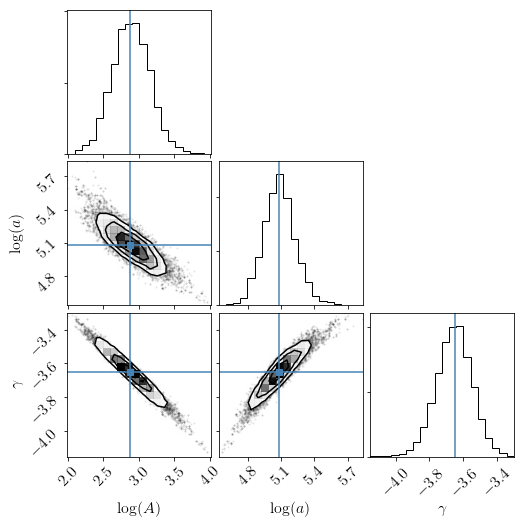

In [492]:
burnt = sampler.chain[:,int(nstep/2)::2,:].reshape(-1,ndim)
corner.corner(burnt, labels=[r'$\log(A)$','$\log(a)$',r'$\gamma$'], truths=result['x']);
plt.savefig('figs/lmodel_corner_rvs.png', bbox_inches='tight')

Text(0.5, 0, '$l_\\mathrm{max}$')

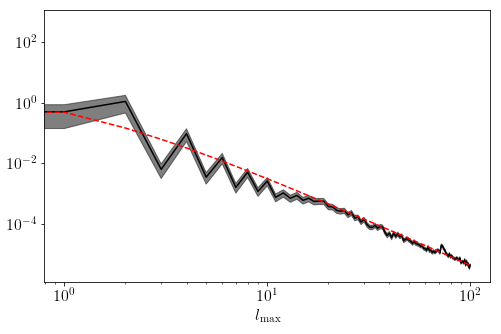

In [519]:
fig = plt.figure(figsize=(8,5))

var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)

plt.plot(lvals, spectrum_full, color='k')
plt.fill_between(lvals, spectrum_full*var_lower, 
                        spectrum_full*var_upper, color='k',
                alpha=0.5)

plt.plot(np.arange(lmax_fit), model(np.arange(lmax_fit), result['x']), '--r')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l_\mathrm{max}$')
#plt.plot([100,100],[1e-20,1e40],'--k', alpha=0.5)

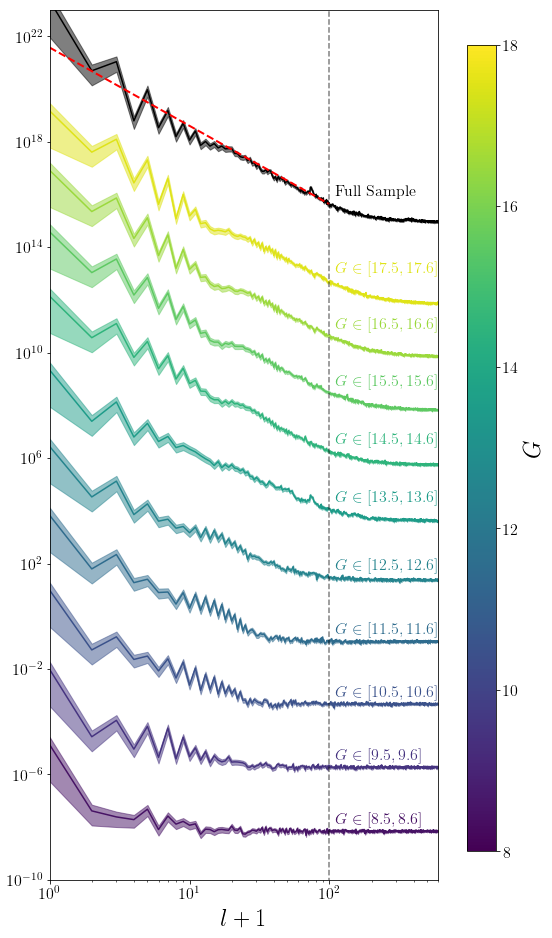

In [520]:
fig = plt.figure(figsize=(8,16))

cmap = cm.viridis; mmin=8.; mmax=18.

high_level=10

lmax=600;
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))
lvals = np.arange(lmax+1)
var_lower = scipy.stats.chi2.ppf(0.16, 2*lvals+1)/(2*lvals+1)
var_upper = scipy.stats.chi2.ppf(0.84, 2*lvals+1)/(2*lvals+1)

with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    for i, mag in tqdm.tqdm_notebook(enumerate(hf['magval'][...]), total=len(hf['magval'][...])):    
        if mag>18: continue
        n_sample = np.zeros(hp.nside2npix(2**high_level))
        n_sample[hf['%.1f' % mag]['hpx'][...]] = hf['%.1f' % mag]['n'][...]
        n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
        k_sample = np.zeros(hp.nside2npix(2**high_level))
        k_sample[hf['%.1f' % mag]['hpx'][...]] = hf['%.1f' % mag]['k_rv'][...]
        k_sample = downsize(k_sample, 2**high_level, nside)[n2r]
        
        x = logit((k_sample+1)/(n_sample+2))

        spectrum = hp.anafast(x, lmax=lmax)
        plt.plot(lvals+1, spectrum*10**(2*float(i)), color=cmap((mag-mmin)/(mmax-mmin)))
        plt.fill_between(lvals+1, spectrum*var_lower*10**(2*float(i)), 
                                spectrum*var_upper*10**(2*float(i)), color=cmap((mag-mmin)/(mmax-mmin)),
                        alpha=0.5)
        
#         plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x'])*10**(2*float(i)) \
#                                  * spectrum[lmax_fit]/model(lmax_fit, result['x']), '--r', alpha=0.7)
        
        plt.text(lmax_fit*1.1, spectrum[lmax_fit]*10**(2*float(i+0.15)), r'$G\in[%.1f,%.1f]$'%(mag,mag+0.1),
                 ha='left', color=cmap((mag-mmin)/(mmax-mmin)))
    
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    n_sample = hf['full']['n'][...]
    n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
    k_sample = hf['full']['k_rv'][...]
    k_sample = downsize(k_sample, 2**high_level, nside)[n2r]
x = logit((k_sample+1)/(n_sample+2))
spectrum_full = hp.anafast(x, lmax=lmax)

plt.plot(lvals+1, spectrum_full*10**(2*float(i-1.5)), color='k')
plt.fill_between(lvals+1, spectrum_full*var_lower*10**(2*float(i-1.5)), 
                        spectrum_full*var_upper*10**(2*float(i-1.5)), color='k',
                alpha=0.5)
plt.plot(np.arange(lmax_fit)+1, model(np.arange(lmax_fit), result['x'])*10**(2*float(i-1.5)), 
         '--r', linewidth=2)
plt.text(lmax_fit*1.1, spectrum_full[lmax_fit]*10**(2*float(i-1.35)), r'Full Sample',
             ha='left', color='k')
    
plt.yscale('log'); plt.xscale('log'); plt.xlabel(r'$l+1$', fontsize=24)
plt.plot([lmax_fit,lmax_fit],[1e-20,1e40],'--k', alpha=0.5)
plt.ylim(1e-10, 1e23)
plt.xlim(1,lmax+1)


# Adding cbar axes to subplots
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
norm = matplotlib.colors.Normalize(vmin=mmin,vmax=mmax)
im = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
im.set_array([])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(r'$G$', fontsize=24)

plt.savefig('figs/powerspectrum_betamean_fit-pl_rvs_nside%d.png' % nside, bbox_inches='tight')

# RVS resampling

In [219]:
high_level=10
nside=256
n2r = hp.ring2nest(nside, np.arange(hp.nside2npix(nside)))
with h5py.File('/data/asfe2/Projects/astrometry/gaia3_astcounts_select_hpx10.h', 'r') as hf:
    n_sample = hf['full']['n'][...]
    n_sample = downsize(n_sample, 2**high_level, nside)[n2r]
    k_sample = hf['full']['k_rv'][...]
    k_sample = downsize(k_sample, 2**high_level, nside)[n2r]

alpha = k_sample+1
beta = n_sample-k_sample+1

sample = scipy.stats.beta.rvs(alpha, beta, size=len(alpha))

pvals = scipy.stats.beta.cdf(sample, alpha, beta)

In [220]:
lmaxs = [10,100,1000]
pvals_lmax = np.zeros((len(lmaxs), len(alpha)))

integral = np.zeros((len(lmaxs), len(alpha)))
for j in tqdm.tqdm_notebook(range(len(lmaxs))):
    alm_map = hp.map2alm(logit(sample), lmax=lmaxs[j])
    _map = hp.alm2map(alm_map, nside, verbose=False)

    pvals_lmax[j] = scipy.stats.beta.cdf(expit(_map), alpha, beta)

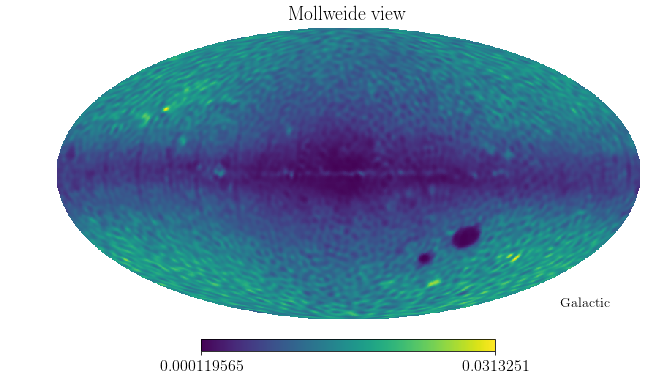

In [221]:
lmax=100
alm_map = hp.map2alm(logit(sample), lmax=lmax)
_map = hp.alm2map(alm_map, nside, verbose=False)
hp.mollview(expit(_map), coord=['C','G'])

#plt.savefig('figs/lmax%d_nside%d.png' % (lmax,nside), bbox_inches='tight')

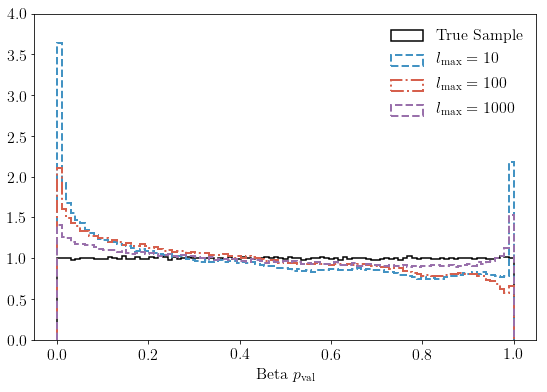

In [222]:
plt.figure(figsize=(9,6))

bins=np.linspace(0,1,100)
plt.hist(pvals, bins=bins, histtype='step', density=True, color='k', linewidth=1.5, label='True Sample');
#plt.hist(pvals_mean, bins=bins, histtype='step', density=True);

colors = [cm.RdBu(0.8), cm.RdBu(0.2), cm.PRGn(0.2)]
linestyles = ['--', '-.', '--']

for j in range(len(lmaxs)):
    plt.hist(pvals_lmax[j], bins=bins, histtype='step', label=r'$l_\mathrm{max}=%d$'%lmaxs[j], density=True, 
             linewidth=2, linestyle=linestyles[j], color=colors[j]);
plt.legend(loc='upper right', ncol=1, frameon=False)#, bbox_to_anchor=(0.5,0.9))
#plt.yscale('log')
plt.ylim(0.,4)
#plt.yticks([0.5,1.,2.,4.])

plt.xlabel(r'Beta $p_\mathrm{val}$')

plt.savefig('figs/BetaPval-test_rvs_nside%d.png' % nside, bbox_inches='tight')

In [527]:
import sqlutilpy, os,sys
home = os.path.expanduser("~")
sys.path.append(home+'/Documents/software/')
import getdata

In [529]:
# Run query to collect aggregate data
query = """select min(phot_g_mean_mag) as min, max(phot_g_mean_mag) as max,
                  min(phot_g_mean_mag) filter (where parallax is not Null) as min_ast,
                  max(phot_g_mean_mag) filter (where parallax is not Null) as max_ast
                from gaia_edr3.gaia_source"""
%time sqlutilpy.get(query, asDict=True, **getdata.sql_args)

CPU times: user 128 ms, sys: 60 ms, total: 188 ms
Wall time: 30min 55s


OrderedDict([('min', array([1.73161], dtype=float32)),
             ('max', array([22.9564], dtype=float32)),
             ('min_ast', array([1.94252], dtype=float32)),
             ('max_ast', array([21.5443], dtype=float32))])